In [19]:
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import LSTM, Dense, LayerNormalization, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
# Импортируйте класс из файла
from preprocess_func_and_classes import BasePeakMarker, read_emg8

np.set_printoptions(suppress=True, precision=4)
# %matplotlib widget

# Data

In [20]:
# protocol = pd.read_csv('data/2024-12-04_12-22-13.emg8.protocol', sep=',', index_col=0)
# LABELS = dict(protocol[['State', 'ID']].value_counts().index)
LABELS = {
 'Neutral': 0,
 'Close': 1,
 'Indication': 8,
 'Open': 2,
 'Pinch': 7,
 'ThumbFingers': 6,
 'Wrist_Extend': 4,
 'Wrist_Flex': 3,
 }

last_train_idx = 5500

In [21]:
SYNC_COL = 'sample'   # порядковый номер размеченного жеста - для синхронизации и группировок
TARGET = 'act_label'  # таргет - метка фактически выполняемого жеста

In [22]:
palm_file = 'new/2024-12-09_11-22-43.emg8'
data = read_emg8(palm_file)
data

,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,omg8,omg9,omg10,omg11,omg12,omg13,omg14,omg15,id,ts,sample
0,14614175.0,12879374.0,8433556.0,9199422.0,10380274.0,10742263.0,10149459.0,12061053.0,14812038.0,12074006.0,14741813.0,14519471.0,14745403.0,11699413.0,13505758.0,12006664.0,0,228630.0,0.0
1,14614702.0,12880539.0,8419582.0,9195542.0,10381431.0,10743668.0,10150130.0,12067421.0,14819044.0,12071085.0,14743318.0,14523262.0,14739463.0,11702904.0,13494134.0,12011390.0,0,228670.0,0.0
2,14611442.0,12874160.0,8414936.0,9191698.0,10382716.0,10744614.0,10147130.0,12067418.0,14816805.0,12073649.0,14747744.0,14529458.0,14739717.0,11694616.0,13490237.0,12005435.0,0,228710.0,0.0
3,14607506.0,12859053.0,8409412.0,9189942.0,10380397.0,10740635.0,10146524.0,12068550.0,14815388.0,12067985.0,14738271.0,14514387.0,14734422.0,11690328.0,13481402.0,11996330.0,0,228750.0,0.0
4,14605974.0,12865563.0,8414829.0,9190501.0,10380651.0,10742064.0,10151900.0,12068572.0,14812374.0,12065675.0,14738897.0,14516334.0,14719776.0,11685535.0,13474244.0,11994670.0,0,228790.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,13604846.0,12463074.0,7765843.0,8062120.0,10298588.0,10828149.0,10391926.0,11417010.0,14862751.0,10705896.0,13910910.0,14485286.0,9951557.0,9366361.0,12126324.0,10625043.0,0,448430.0,70.0
5496,13575858.0,12436992.0,7760089.0,8051339.0,10295352.0,10826865.0,10388727.0,11418092.0,14865724.0,10704565.0,13913132.0,14486991.0,9940591.0,9358721.0,12116466.0,10620414.0,0,448470.0,70.0
5497,13542104.0,12412006.0,7739251.0,8027382.0,10297029.0,10817494.0,10391943.0,11414077.0,14865380.0,10705280.0,13906815.0,14478145.0,9938390.0,9351753.0,12104252.0,10616085.0,0,448510.0,70.0
5498,13509265.0,12389583.0,7720936.0,8005883.0,10291492.0,10808563.0,10390633.0,11408238.0,14864675.0,10701265.0,13903619.0,14471912.0,9928493.0,9338664.0,12095748.0,10616206.0,0,448550.0,70.0


In [23]:
#palm_file = 'data/new/2024-12-09_11-22-43.emg8'
#gestures = pd.read_csv(palm_file, sep= ' ', on_bad_lines='warn')
#gestures = gestures.query('id != -1')

#display(gestures.head())

#GESTURES = gestures['state'].unique()
# renumerate gestures from zero
#gestures['id'] = gestures['state'].replace({gesture: i for i, gesture in enumerate(GESTURES)})

#display(gestures[['id', 'state']].drop_duplicates())

In [24]:
GESTURES = ['Neutral', 'ThumbFingers', 'Close', 'Open', 'Pinch', 'Indication',
       'Wrist_Flex', 'Wrist_Extend']

In [25]:
#gestures.columns

In [26]:
N_OMG_CH = 16

OMG_CH = [f'omg{i}' for i in range(N_OMG_CH)]

print(f"OMG_CH: {list(OMG_CH)}")

OMG_CH: ['omg0', 'omg1', 'omg2', 'omg3', 'omg4', 'omg5', 'omg6', 'omg7', 'omg8', 'omg9', 'omg10', 'omg11', 'omg12', 'omg13', 'omg14', 'omg15']


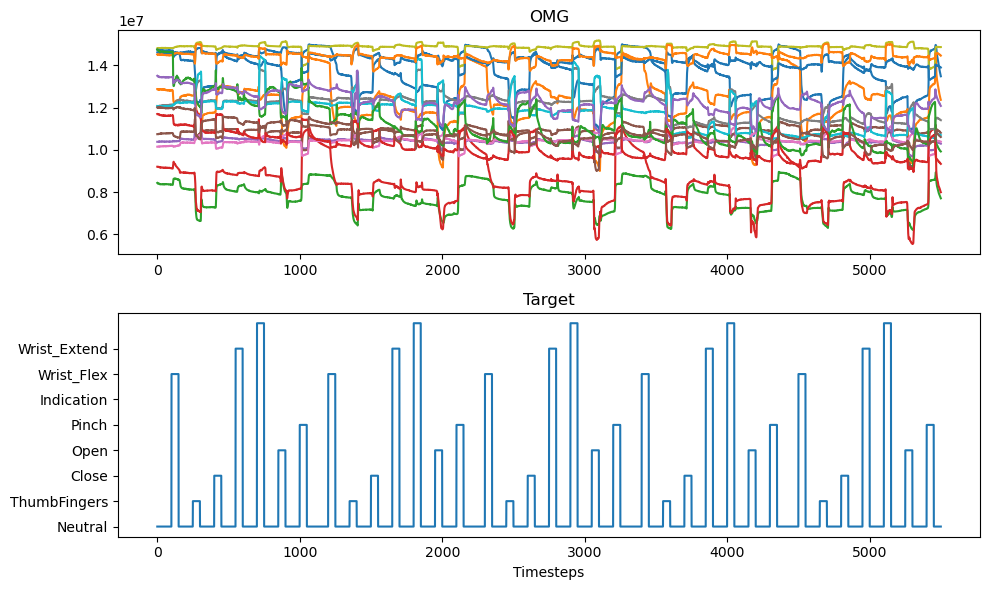

In [27]:
fig, axx = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(axx[0])
plt.plot(data[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(data['id'].values)
plt.title('Target')
plt.yticks(np.arange(len(GESTURES)), GESTURES)

plt.xlabel('Timesteps')
plt.tight_layout()

# Dataset forming

In [28]:
#gestures

In [29]:
def split_data(data_marked, last_train_idx=last_train_idx):
    X = data_marked[OMG_CH]
    y = data_marked['act_label']
    
    X_train = X[OMG_CH].values[:last_train_idx]
    y_train = y.values[:last_train_idx]

    X_test = X[OMG_CH].values[last_train_idx:]
    y_test = y.values[last_train_idx:]

    return X_train, X_test, y_train, y_test

In [30]:
marker = BasePeakMarker(bounds_shift=-2)
marker.fit(data)

data_marked, bounds = marker._mark(data)

X_train, X_test, y_train, y_test = split_data(data_marked, last_train_idx=3300)

In [31]:
y = data_marked['act_label']
y.value_counts()

act_label
0    3910
2     243
6     233
4     232
7     227
8     222
1     218
3     215
Name: count, dtype: int64

In [32]:
#last_train_idx = 3300
#X_train = gestures[OMG_CH].values[:last_train_idx]
#y_train = gestures['id'].values[:last_train_idx]

#X_test = gestures[OMG_CH].values[last_train_idx:]
#y_test = gestures['id'].values[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3300, 16) (3300,)
(2200, 16) (2200,)


In [33]:
# Функция для создания последовательностей
def create_sequences(data, labels, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps + 1):
        X.append(data[i:i + timesteps])
        y.append(labels[i + timesteps - 1])
    return np.array(X), np.array(y)

# Функция для создания последовательностей и кодирования меток
def prepare_sequences(X_train_array, X_test_array, y_train_array, y_test_array, timesteps=1):
    # Проверка и преобразование в np.ndarray
    if not isinstance(X_train_array, np.ndarray):
        X_train_array = np.array(X_train_array)
    if not isinstance(y_train_array, np.ndarray):
        y_train_array = np.array(y_train_array)
    if not isinstance(X_test_array, np.ndarray):
        X_test_array = np.array(X_test_array)
    if not isinstance(y_test_array, np.ndarray):
        y_test_array = np.array(y_test_array)

    X_train_seq, y_train_seq = create_sequences(X_train_array, y_train_array, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_array, y_test_array, timesteps)

    # Использование LabelEncoder для преобразования меток в целочисленные значения
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_seq)
    y_test_encoded = label_encoder.transform(y_test_seq)

    # Преобразование меток в one-hot кодировку
    y_train_encoded = to_categorical(y_train_encoded)
    y_test_encoded = to_categorical(y_test_encoded)

    return X_train_seq, X_test_seq, y_train_encoded, y_test_encoded, label_encoder

# Функция для оценки модели с использованием кросс-валидации
def build_evaluate_model(timesteps, X_train_seq, y_train_encoded, X_test_seq, y_test_encoded):
    # Построение модели
    model = Sequential([
        LSTM(64, input_shape=(timesteps, X_train_seq.shape[2]), return_sequences=True),
        LayerNormalization(),
        Dropout(0.05),
        LSTM(128, return_sequences=True),
        LayerNormalization(),
        Dropout(0.05),
        LSTM(64, return_sequences=False),
        LayerNormalization(),
        Dense(32, activation='relu'),
        Dense(y_train_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Кросс-валидация
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(X_train_seq):
        X_train_fold, X_val_fold = X_train_seq[train_index], X_train_seq[val_index]
        y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

        model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=0)
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracies.append(val_accuracy)

    print(f"Average validation accuracy: {np.mean(accuracies)}")

    # Обучение модели на всех тренировочных данных
    model.fit(X_train_seq, y_train_encoded, epochs=25, batch_size=64, verbose=0)

    # Оценка на тестовых данных
    test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_encoded, verbose=0)
    print(f"Test accuracy: {test_accuracy}")

    return np.mean(accuracies), test_accuracy, model


In [ ]:
# Функция для валидации timesteps
def validate_timesteps(X_train, X_test, y_train, y_test, timesteps_values=[1, 2, 3, 4]):
    best_timesteps = None
    best_val_accuracy = 0
    best_test_accuracy = 0

    for timesteps in timesteps_values:
        # Создание последовательностей и кодирование меток
        X_train_seq, X_test_seq, y_train_encoded, y_test_encoded, label_encoder = prepare_sequences(
            X_train, X_test, y_train, y_test, timesteps
        )

        val_accuracy, test_accuracy, model = build_evaluate_model(timesteps, X_train_seq, y_train_encoded, X_test_seq, y_test_encoded)
        print(f"Timesteps: {timesteps}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_test_accuracy = test_accuracy
            best_timesteps = timesteps
            best_model = model

    print(f"Best Timesteps: {best_timesteps}, Best Validation Accuracy: {best_val_accuracy}, Best Test Accuracy: {best_test_accuracy}")

    return best_timesteps, best_model

In [ ]:
# Пример использования функции validate_timesteps
best_timesteps, best_model = validate_timesteps(X_train, X_test, y_train, y_test)

best_model.save('model/lstm_model.h5')

Average validation accuracy: 0.8145454525947571
Test accuracy: 0.8222727179527283
Timesteps: 1, Validation Accuracy: 0.8145454525947571, Test Accuracy: 0.8222727179527283
Average validation accuracy: 0.7290095686912537
Test accuracy: 0.528876781463623
Timesteps: 2, Validation Accuracy: 0.7290095686912537, Test Accuracy: 0.528876781463623
Average validation accuracy: 0.797762413819631
Test accuracy: 0.8075523376464844
Timesteps: 3, Validation Accuracy: 0.797762413819631, Test Accuracy: 0.8075523376464844
Average validation accuracy: 0.7995147109031677
Test accuracy: 0.670914888381958
Timesteps: 4, Validation Accuracy: 0.7995147109031677, Test Accuracy: 0.670914888381958
Average validation accuracy: 0.729674498240153
Test accuracy: 0.7030965685844421
Timesteps: 5, Validation Accuracy: 0.729674498240153, Test Accuracy: 0.7030965685844421
Best Timesteps: 1, Best Validation Accuracy: 0.8145454525947571, Best Test Accuracy: 0.8222727179527283
Количество уникальных классов: 8


In [37]:
X_train_seq, X_test_seq, y_train_encoded, y_test_encoded, label_encoder = prepare_sequences(X_train, X_test, y_train, y_test)

# Modeling

Модель уже обучилась в функции build_evaluate_model

```py
model = Sequential([
        LSTM(64, input_shape=(best_timesteps, X_train_seq.shape[2]), return_sequences=True),
        LayerNormalization(),
        # Dropout(0.05),
        LSTM(128, return_sequences=True),
        LayerNormalization(),
        # Dropout(0.05),
        LSTM(64, return_sequences=False),
        LayerNormalization(),
        Dense(32, activation='relu'),
        Dense(y_train_encoded.shape[1], activation='softmax')
    ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели на всех тренировочных данных
model.fit(X_train_seq, y_train_encoded, epochs=20, batch_size=32, verbose=0)
```

In [ ]:
import seaborn as sns

#plt.figure(figsize=(10, 3)) # 
#sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
#plt.tight_layout()

## Prediction

In [38]:
# Функция для предсказания наивероятнейшего жеста руки
def predict(model, X_test_seq):
    y_pred_encoded = model.predict(X_test_seq)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    return y_pred

In [39]:
# Применение функции predict для получения индексов максимальных элементов
y_pred_train_indices = predict(best_model, X_train_seq)
y_pred_test_indices = predict(best_model, X_test_seq)

69/69 [==============================] - 0s 2ms/step


In [40]:
# Получение уникальных классов и их количества
unique_classes = np.unique(y_pred_test_indices)
num_classes = len(unique_classes)

print(f"Уникальные классы: {unique_classes}")
print(f"Количество классов: {num_classes}")

Уникальные классы: [0 1 3 4 7]
Количество классов: 5


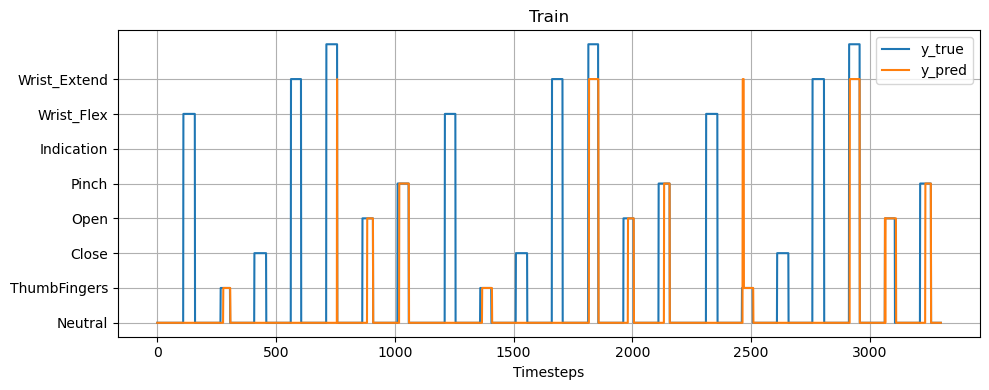

In [41]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train_indices, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

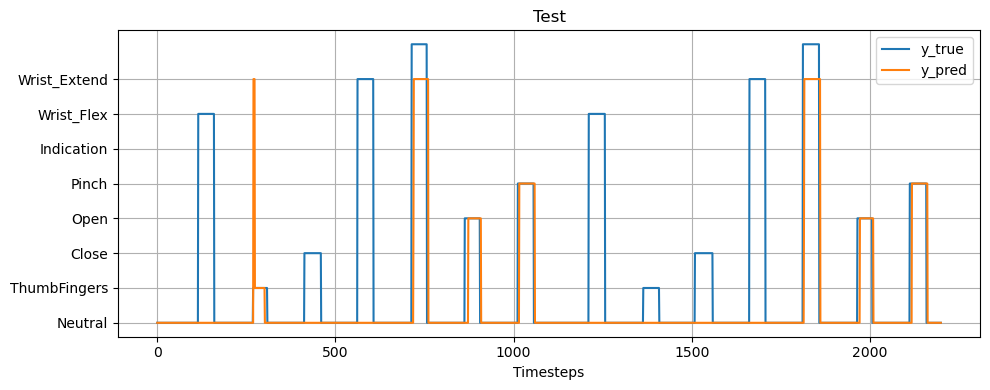

In [42]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test_indices, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [340]:
GESTURES

array(['Neutral', 'ThumbFingers', 'Close', 'Open', 'Pinch', 'Indication',
       'Wrist_Flex', 'Wrist_Extend'], dtype=object)

In [47]:
from sklearn.metrics import classification_report

#print(classification_report(y_train_encoded, y_pred_train_indices, target_names=GESTURES))
#print(classification_report(y_test_seq[2:], y_pred_test_indices, target_names=GESTURES))

# Real-time inference

In [48]:
import time
import serial
from copy import deepcopy

In [111]:
np.unique(y_dct['y_predicted'])

array([0, 1], dtype=int64)

In [106]:
y_pred_encoded = best_model.predict(X_seq)
y_pred = np.argmax(y_pred_encoded, axis=1)[0]
y_pred_encoded

1/1 [==============================] - 0s 68ms/step


array([[0.0629, 0.9359, 0.    , 0.001 , 0.    , 0.    , 0.    , 0.0001]],
      dtype=float32)

## Inference Utils: Put your code here

In [112]:
def preprocessing(buffer, omg_sample, best_timesteps):
    buffer.append(omg_sample)
    
    # Функция для создания последовательностей
    def create_sequences(data, timesteps):
        X = []
        for i in range(len(data) - timesteps + 1):
            X.append(data[i:i + timesteps])
        return np.array(X)
    
    if len(buffer) >= best_timesteps:
        X_seq = create_sequences(np.array(buffer), best_timesteps)
        # Убедимся, что X_seq имеет правильную форму
        X_seq = X_seq[-1].reshape((1, best_timesteps, N_OMG_CH))
        return X_seq, buffer
    else:
        return None, buffer
    
    
# Функция для выполнения инференса (предсказания)
def inference(model, X_seq):
    y_pred_prob = model.predict(X_seq)
    #y_pred = np.argmax(y_pred_prob, axis=1)[0]  # Получаем скалярное значение
    return y_pred_prob

def postprocessing(y_pred_prob, GESTURES):
    y_pred_prob
    return y

In [ ]:
# Основной цикл для обработки данных в реальном времени
def process_realtime_data(input_file_path, output_file_path, model, best_timesteps):
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'a') as output_file:
        buffer = []
        prev_prediction = None

        while True:
            start_time = time.time()
            line = input_file.readline()
            if not line:
                break
            data = list(map(float, line.strip().split(',')))
            data = preprocessing(data, best_timesteps)
            buffer.append(data)

            if len(buffer) >= best_timesteps:
                X_seq = create_sequences(np.array(buffer), best_timesteps)
                predicted_gestures = inference(model, X_seq)
                #final_prediction = postprocessing(predicted_gestures, prev_prediction)
                #prev_prediction = final_prediction

                # Запись результата в файл
                output_file.write(f"{predicted_gestures}\n")

                buffer.pop(0)  # Удаляем первый элемент буфера

            elapsed_time = time.time() - start_time
            sleep_time = max(0.040 - elapsed_time, 0)
            time.sleep(sleep_time)

# Пример использования
input_file_path = 'path/to/your/input/file.csv'
output_file_path = 'logs/results.txt'
# model = load_model('path/to/your/model.h5')  # Загрузка обученной модели

process_realtime_data(input_file_path, output_file_path, best_model, best_timesteps)

## Inference

### Offline (dataset)

In [131]:
df_sim = data.iloc[3300:]
print(df_sim.shape)

(2200, 19)


In [136]:
# Основной цикл для обработки данных в реальном времени
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0

y_previous = None
y_dct = {
    'omg_sample': [],
    'sample_preprocessed': [],
    'y_predicted': [],
    'y_postprocessed': [],
}

buffer = []

while True:
    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        td_ts, omg_sample, _ = np.array_split(sample, [2, 2 + N_OMG_CH])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    X_seq, buffer = preprocessing(buffer, omg_sample.astype(float), best_timesteps)
    if X_seq is not None:
        sample_preprocessed = X_seq
    else:
        continue
    # [/Data preprocessing]

    # [Inference]
    y_predicted = inference(best_model, sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    # NO COMMANDS FORMING IN SIMULATION
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        # Sanity check: Sizes of SAMPLE=65, OMG=16
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')

    ts_diff = time.time() - ts_start
    # assert(ts_diff < TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

1/1 [==============================] - 0s 33ms/step


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

ValueError: Input could not be cast to an at-least-1D NumPy array

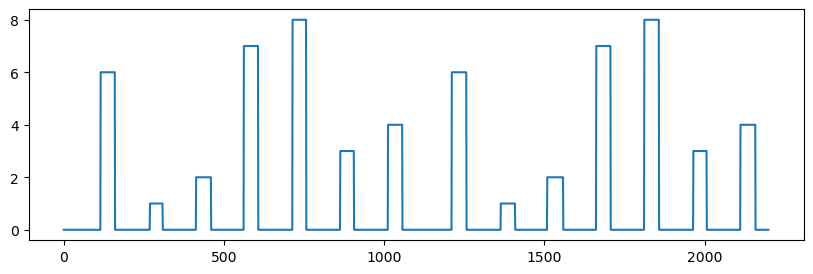

In [139]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
# print(classification_report(y_test, y_dct['y_postprocessed'].argmax(axis=1), target_names=GESTURES))

ValueError: Found input variables with inconsistent numbers of samples: [2200, 1129]

### Online

#### Virtual hand

In [21]:
import VirtualPhantom
vp = VirtualPhantom.VirtualPhantomClient('localhost', 1755)

In [22]:
GESTURES

array(['Neutral', 'ThumbFingers', 'Close', 'Open', 'Pinch', 'Indication',
       'Wrist_Flex', 'Wrist_Extend'], dtype=object)

In [126]:
# Bindings for virtual hand
def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # Pilot Neutral
        pass # Do nothing
    elif x == 1: # Pilot thumb_fingers
        # Virtual Hand thumb_fingers
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 2: # Pilot close_state
        # Virtual Hand close_state
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 3: # Pilot open_state
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 4: # Pilot pinch_state
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 5: # Pilot indication_state
        cmd.update({ 'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 6: # Wrist_Flex
        cmd.update({'wrist_flex': 1})
    elif x == 7: # Wrist_Extend
        cmd.update({'wrist_extend': 1})
    else:
        pass # Do nothing
    
    return cmd

In [24]:
!ls /dev/ttyACM* /dev/ttyUSB*

/bin/bash: /home/user/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ls: cannot access '/dev/ttyUSB*': No such file or directory
 /dev/ttyACM0


In [ ]:
ser_name = '/dev/ttyACM0'
try:
    ser.close()
except:
    pass
ser = serial.Serial(ser_name, baudrate=115200, timeout=60);

ser.write('PT1\r\n'.encode())
time.sleep(0.1)
ser.write('Pt1\r\n'.encode())
time.sleep(0.1)
ser.flush()
time.sleep(0.1)

def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

In [128]:
TIMEOUT = 0.033
DEBUG = True

while(ser.in_waiting>50):
    ser.readline()
    time.sleep(0.005)
ser.readline()
    
t_start = time.time()
prev_idx = -1

y_previous = None
while True:    
    
    # [Data reading]
    t_rel = time.time() - t_start
    
    try: 
        data = parseline()
        data_line = ' '.join(data.astype(str))
        data_line += f' {-1} {"Inference"} {-1} {t_rel:.2f}'
    except Exception as e:
        raise(e)
        data_line = ' '.join(['-1']*n_cols)
        data_line += f' {-1} {"Error"} {-1} {t_rel:.2f}'

    td_ts, omg_sample, _ = np.array_split(data, [2, 2 + N_OMG_CH])        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed   = preprocessing(omg_sample.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted           = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed       = postprocessing(y_predicted, y_previous)
    y_postprocessed_label = y_postprocessed.argmax()
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed_label)
    # [/Commands composition]
    
    # [Commands sending]
    prot_idx = deepcopy(y_postprocessed_label)
    if (prot_idx != prev_idx):
        vp.send_cmd(**y_commands)
        prev_idx = deepcopy(prot_idx)
    # [/Commands sending]
    
    # [Data logging]
    # [/Data logging]

    y_previous = y_postprocessed.copy()
    time.sleep(0.001)
    t_rel = time.time() - t_start
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        # print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
        # print(GESTURES[y_postprocessed_label], sample_preprocessed.tolist(), end='             \r')
        print(GESTURES[y_postprocessed_label], y_predicted, end='             \r')
    
    # assert(t_rel<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'

NameError: name 'ser' is not defined